Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [785]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import math
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/filip/anaconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['ones']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [786]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [787]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [788]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

1.0


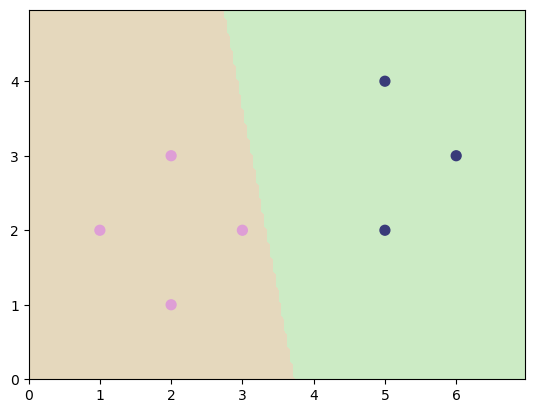

In [789]:
classifier = RidgeClassifier(alpha=0).fit(seven_X, seven_y)
predictions = classifier.predict(seven_X)
print(accuracy_score(seven_y, predictions))
plot_2d_clf_problem(seven_X, seven_y, h = lambda x : calssifier.predict(x) >= 0.5)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

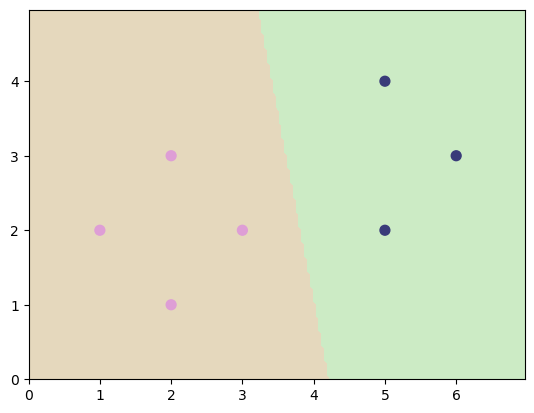

In [790]:
calssifier = LinearRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, h = lambda x : calssifier.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [791]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

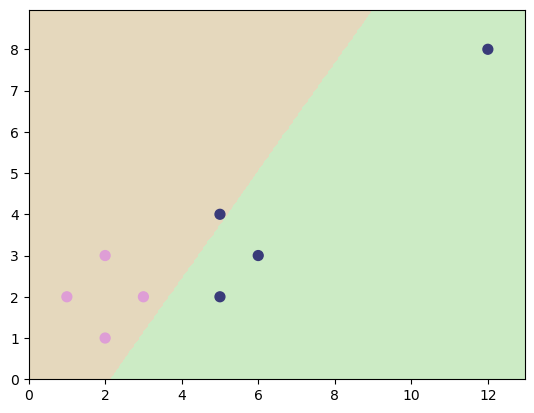

In [792]:
calssifier = LinearRegression().fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, h = lambda x : calssifier.predict(x) >= 0.5)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [793]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

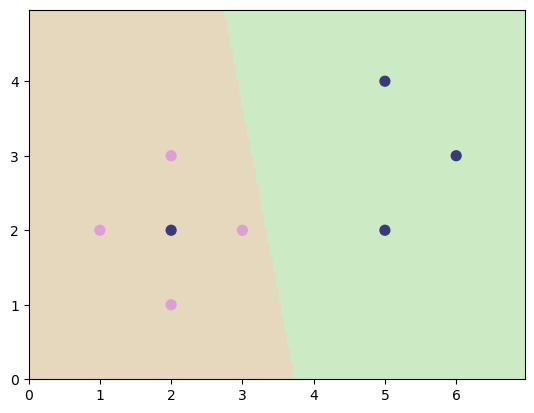

In [794]:
calssifier = LinearRegression().fit(unsep_X, unsep_y)
plot_2d_clf_problem(unsep_X, unsep_y, h = lambda x : calssifier.predict(x) >= 0.5)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

[[ 1.41991225  0.49727178]
 [-0.83548831 -0.20415101]
 [ 0.53740498 -0.70460506]
 [-0.21048661  2.60981458]
 [ 1.98543948 -1.62461035]
 [ 2.26776103 -1.8439962 ]
 [ 1.53972737 -1.39091229]
 [ 1.37693046 -1.29088612]
 [ 2.65594206 -2.09793222]
 [ 2.47772373 -0.90356269]
 [-1.31603632 -2.30484611]
 [ 1.15931068 -1.09469704]
 [ 0.33990446 -0.55348924]
 [ 0.28794209 -0.49654907]
 [ 2.75543523 -2.23433872]
 [ 0.28323809 -0.53582445]
 [-1.16979931 -0.70370355]
 [ 1.59669364  0.61488119]
 [-0.20202894 -0.50900997]
 [ 2.31057211 -0.10954282]
 [ 1.42867732  0.95687429]
 [ 1.4059494  -1.25902534]
 [ 1.26707612 -1.1792943 ]
 [ 1.64574026 -1.46878939]
 [ 2.01663289  0.32310322]
 [ 1.41836609 -1.28893803]
 [ 2.37372606 -1.9169158 ]
 [ 1.23042587  1.5984159 ]
 [ 0.52576733 -0.19069066]
 [-1.46893998 -1.62334246]
 [-1.54487816 -1.77570209]
 [-0.40104482 -1.18917842]
 [ 0.72790921  1.08068069]
 [ 0.58635688 -0.71138132]
 [ 0.99317582 -1.01223337]
 [-1.53687441 -1.1184842 ]
 [ 1.80398382 -1.50263582]
 

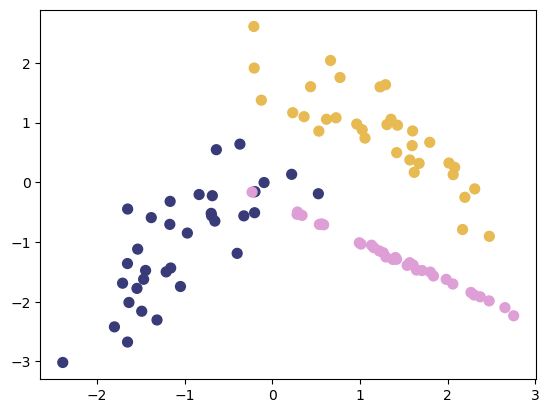

In [795]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 100, n_features = 2, n_informative = 2, n_redundant = 0, n_classes = 3, n_clusters_per_class = 1)
plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

[1 0 2 1 2 2 2 2 2 2 0 2 0 0 2 0 0 1 0 1 1 2 2 2 1 2 2 1 1 0 0 0 1 2 2 0 2
 0 0 0 2 0 1 1 2 0 0 1 1 1 0 2 2 0 2 2 1 2 2 2 0 1 0 1 1 0 0 0 1 1 0 2 1 1
 1 1 1 0 0 1 1 1 0 0 0 2 2 2 1 0 2 1 0 1 1 1 0 0 0 0]


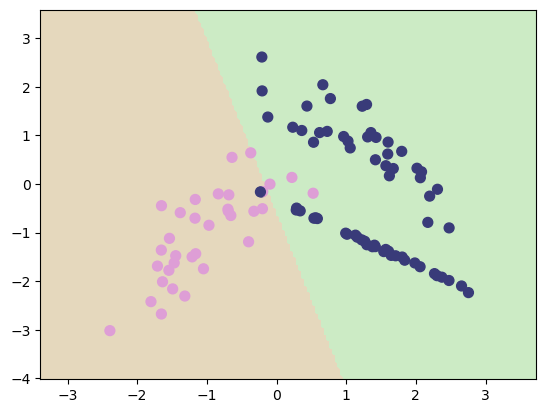

In [796]:
y0 =[]
y1 = []
y2 = []
for el in y:
    if el == 0:
        y0.append(1)
        y1.append(0)
        y2.append(0)
    elif el == 1:
        y0.append(0)
        y1.append(1)
        y2.append(0)
    else:
        y0.append(0)
        y1.append(0)
        y2.append(1)
        
calssifier1 = LinearRegression().fit(X, y0)
calssifier2 = LinearRegression().fit(X, y1)
calssifier3 = LinearRegression().fit(X, y2)

def predict(x, h1, h2, h3):
    pred1 = h1.predict(x)
    pred2 = h2.predict(x)
    pred3 = h3.predict(x)
    getValues = []
    for i in range(len(x)):
        
        if pred1[i] >= pred2[i] and pred1[i] >= pred3[i]:
            getValues.append(0)
        
        elif pred2[i] >= pred1[i] and pred2[i] >= pred3[i]:
            getValues.append(1)

        else:
            getValues.append(2)
    return np.array(getValues)

plot_2d_clf_problem(X, y0, h = lambda x : calssifier1.predict(x) >= 0.5)


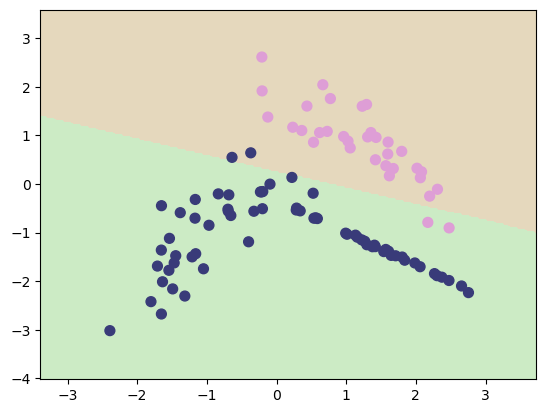

In [797]:
plot_2d_clf_problem(X, y1, h = lambda x : calssifier2.predict(x) >= 0.5)


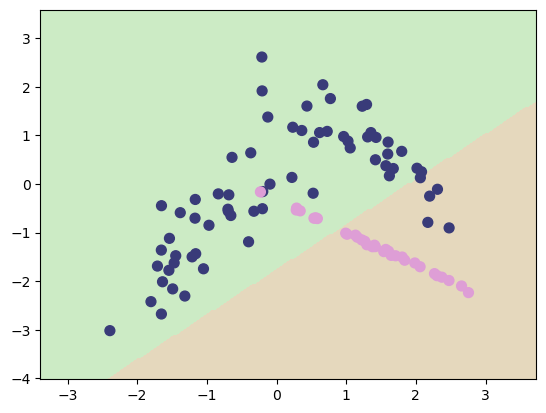

In [798]:
plot_2d_clf_problem(X, y2, h = lambda x : calssifier3.predict(x) >= 0.5)


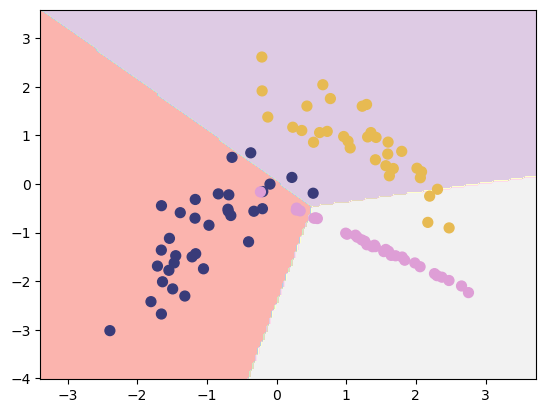

In [799]:
plot_2d_clf_problem(X, y, h = lambda x : predict(x,calssifier1, calssifier2, calssifier3))

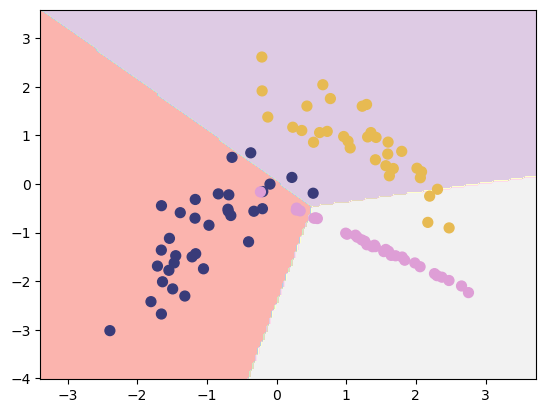

In [800]:
full_cassifier = RidgeClassifier().fit(X,y)
plot_2d_clf_problem(X, y, h = lambda x : predict(x,calssifier1, calssifier2, calssifier3))

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

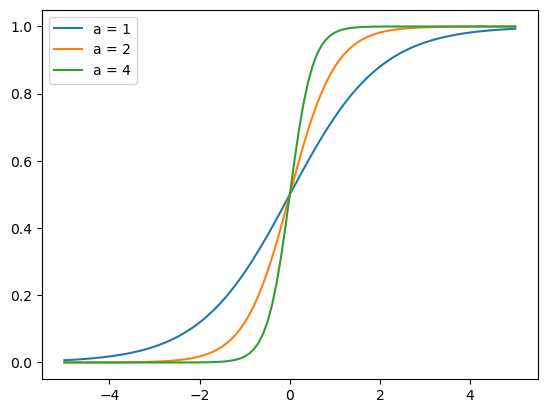

In [801]:
def sigm(x, a=1):
    return 1/(1 + math.exp(-a*x))

x = [x * 0.1 for x in range(int(-5 / 0.1), int(5 / 0.1) + 1)]

a = [1,2,4]
for el in a:
    y=[]
    for el2 in x:
        y.append(sigm(el2,el))
    plt.plot(x,y, label = f'a = {el}')
plt.legend()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [802]:
from numpy import linalg
X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
y = np.array([1, 1, 1, 1, 0, 0, 0])

def lr_h(x,w):
    x = np.array(x)
    predictions = []
    for el in x:
        predictions.append(sigm(np.dot(el, w)[0]))
    
    return np.array(predictions)

def cross_entropy_error(X,y,w):
    X = np.array(X)
    pred = lr_h(X,w)
    y = np.array(y)
    return -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    old_w = []
    ones = np.ones((len(X),1))
    X = np.hstack((ones, X))
    w = np.zeros((len(X[0]),1))
    err = cross_entropy_error(X,y,w)
    for i in range(max_iter):
        pred = lr_h(X,w)
        w[0] =  w[0] - (eta*np.dot(pred-y,X)[0])
        w[1:] = w[1:]*(1- eta*alpha) - (eta*np.dot(pred-y,X)[1:]).reshape(2,1)
        old_w.append(w.copy())
        new_err = cross_entropy_error(X,y,w)
        if(abs(err-new_err) < epsilon):
            break
        err = new_err
    if trace:
        return (old_w, w)
    return w
        
lr_train(X,y)     

array([[ 4.45449454],
       [-1.71089242],
       [ 0.68413507]])

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [803]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

0.13521872720206746


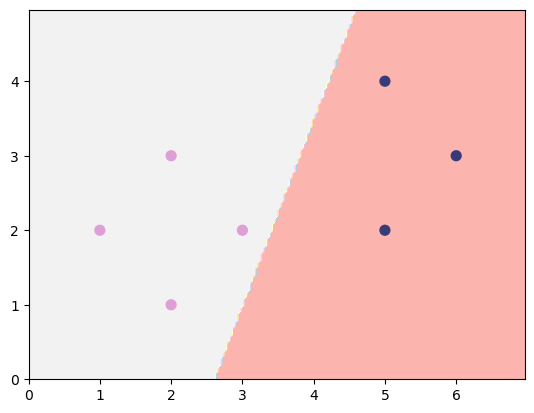

In [804]:
w = lr_train(seven_X, seven_y)
ones = np.ones((len(X),1))

plot_2d_clf_problem(seven_X, seven_y, 
                            h=lambda X : np.array([1 if sigm(np.dot(np.insert(x, 0, 1), w)[0]) >= 0.5 else 0 for x in X]))
seven_X = np.hstack((ones, seven_X))
print(cross_entropy_error(seven_X, seven_y, w))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [805]:
from sklearn.metrics import zero_one_loss

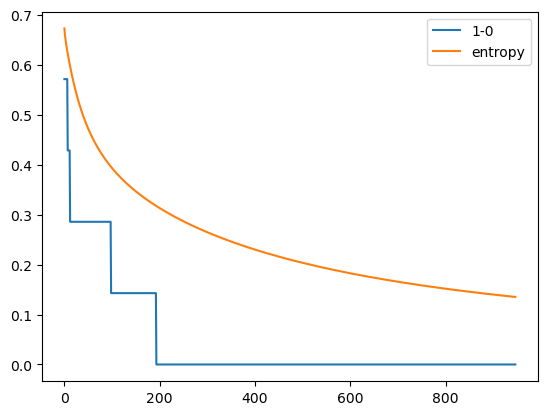

In [806]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
W = lr_train(seven_X, seven_y, trace = True)
zol = []
cee = []

num_iter = [i for i in range(len(W[0]))]
for w3 in W[0]:
    seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
    predictions = np.array([1 if sigm(np.dot(np.insert(x, 0, 1), w3)[0]) >= 0.5 else 0 for x in seven_X])
    seven_X = np.hstack((ones, seven_X))
    zol.append(zero_one_loss(seven_y, predictions))
    cee.append(cross_entropy_error(seven_X,seven_y,w3))


plt.plot(num_iter, zol, label='1-0')
plt.plot(num_iter, cee, label='entropy')
plt.legend()

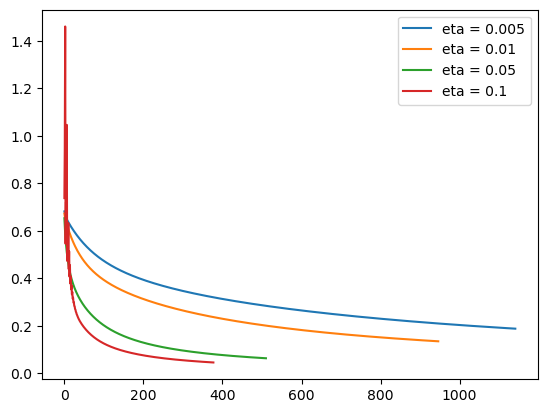

In [807]:
etaList = [0.005,0.01,0.05,0.1]

num_iter = [i for i in range(len(W[0]))]
for el in etaList:
    seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
    W = lr_train(seven_X, seven_y, trace = True, eta = el)
    seven_X = np.hstack((ones, seven_X))
    num_iter = [i for i in range(len(W[0]))]
    cee = []
    for w3 in W[0]:
        cee.append(cross_entropy_error(seven_X,seven_y,w3))
    plt.plot(num_iter, cee, label=f'eta = {el}')
plt.legend()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

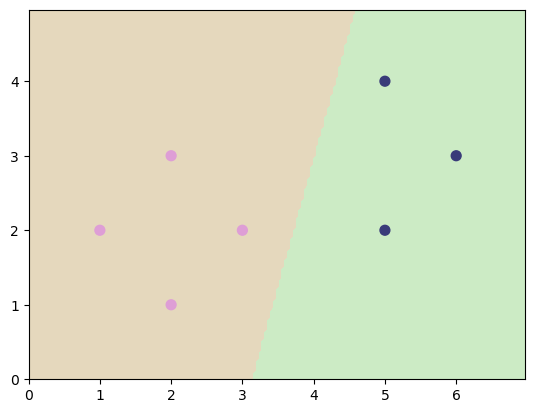

In [808]:
from sklearn.linear_model import LogisticRegression
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
regression = LogisticRegression(C=1000000000, tol = 0.0001, max_iter =2000).fit(seven_X,seven_y)

plot_2d_clf_problem(seven_X, seven_y, lambda x : regression.predict(x) >= 0.5)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [809]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

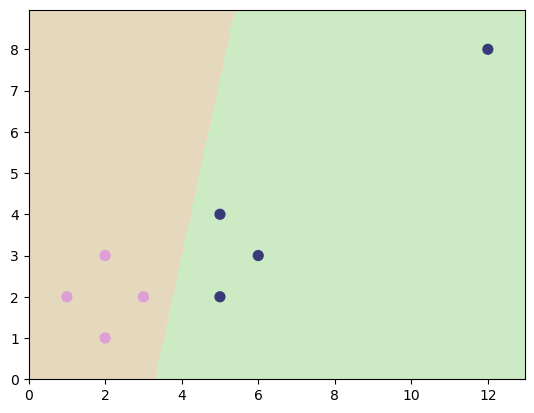

In [810]:
regression = LogisticRegression(C=1000000000, tol = 0.0001, max_iter =2000).fit(outlier_X,outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x : regression.predict(x) >= 0.5)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

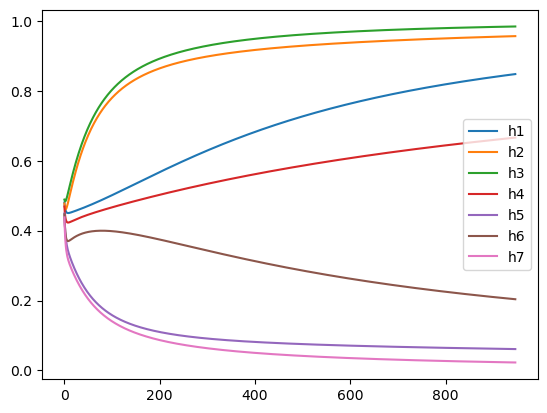

In [811]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

W = lr_train(seven_X, seven_y, trace = True)
seven_X = np.hstack((ones, seven_X))
num_iter = [i for i in range(len(W[0]))]
pred = [[], [], [], [], [], [], []]
w = [[], [], []]
for w1 in W[0]:
    predictions = lr_h(seven_X,w1)
    for i in range(len(predictions)):
        pred[i].append(predictions[i])
    for i in range(3):
        w[i].append(w1[i][0])
        
    

for i in range(len(pred)):
    plt.plot(num_iter, pred[i], label=f'h{i+1}')

plt.legend()

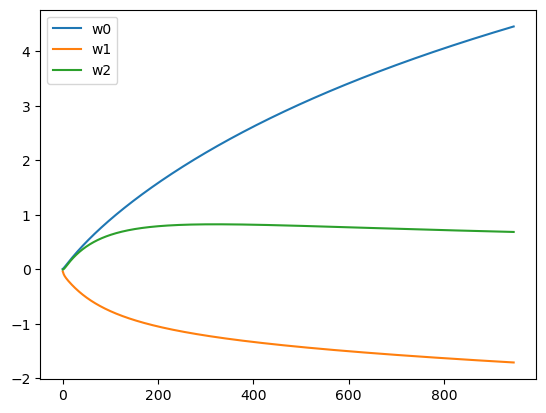

In [812]:
for i in range(len(w)):
    plt.plot(num_iter, w[i], label=f'w{i}')
plt.legend()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [813]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

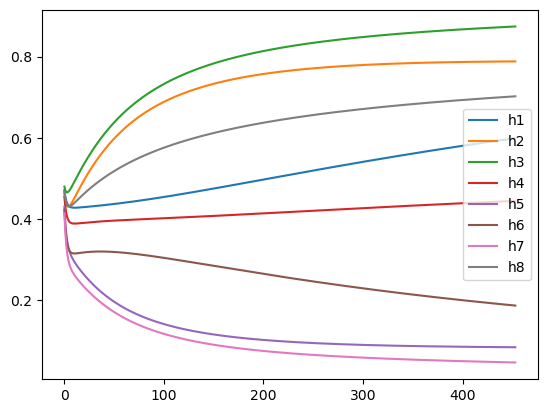

In [814]:
W = lr_train(unsep_X, unsep_y, trace = True)
ones = np.ones((len(unsep_X),1))
unsep_X = np.hstack((ones, unsep_X))
num_iter = [i for i in range(len(W[0]))]
pred = [[], [], [], [], [], [], [],[]]
w = [[], [], []]
for w1 in W[0]:
    predictions = lr_h(unsep_X,w1)
    for i in range(len(predictions)):
        pred[i].append(predictions[i])
    for i in range(3):
        w[i].append(w1[i][0])
        
    

for i in range(len(pred)):
    plt.plot(num_iter, pred[i], label=f'h{i+1}')
    
plt.legend()

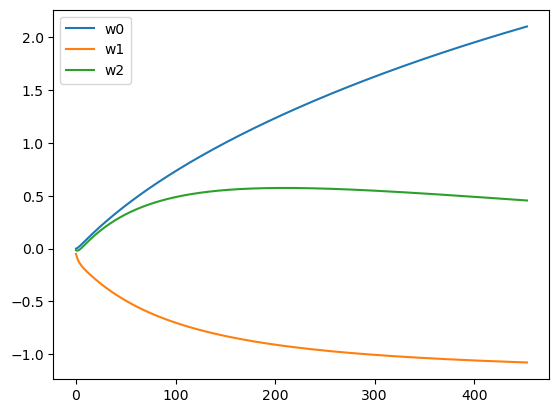

In [815]:
for i in range(len(w)):
    plt.plot(num_iter, w[i], label=f'w{i}')
plt.legend()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [816]:
from numpy.linalg import norm

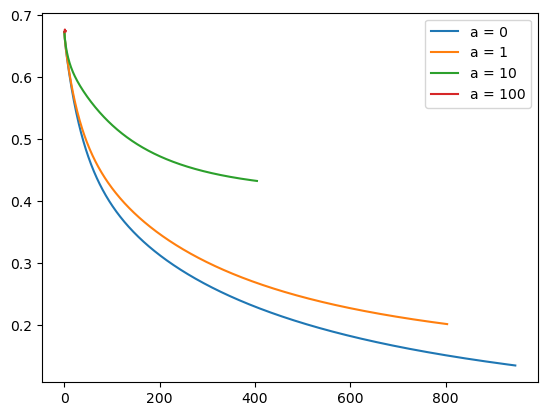

In [817]:
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
a = [0,1,10,100]

ones = np.ones((len(seven_X),1))

for el in a:
    error = []
    seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
    W = lr_train(seven_X, seven_y, trace = True, alpha=el)
    seven_X = np.hstack((ones, seven_X))
    num_iter = [i for i in range(len(W[0]))]
    for w in W[0]:
        error.append(cross_entropy_error(seven_X,seven_y,w))
    
    plt.plot(num_iter, error, label =f'a = {el}')
        
plt.legend()
        
    


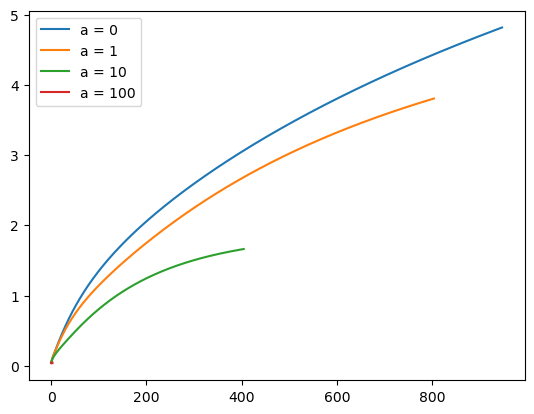

In [818]:
for el in a:
    normal = []
    seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
    W = lr_train(seven_X, seven_y, trace = True, alpha=el)
    seven_X = np.hstack((ones, seven_X))
    num_iter = [i for i in range(len(W[0]))]
    for w in W[0]:
        normal.append(norm(w))
    plt.plot(num_iter, normal, label =f'a = {el}')
        
plt.legend()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [819]:
from sklearn.preprocessing import PolynomialFeatures



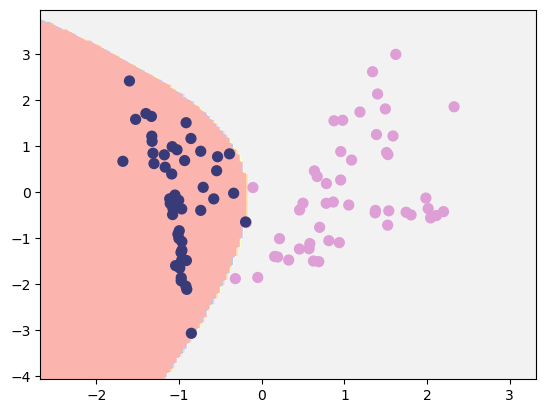

In [820]:
from sklearn.datasets import make_classification

X,y = make_classification(n_features = 2,n_clusters_per_class=2, n_redundant = 0, n_repeated = 0)

poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)

X2 = poly2.fit_transform(X)
X3 = poly3.fit_transform(X)

regression1 = LogisticRegression(C=1000000000, tol = 0.0001, max_iter =2000)
regression1.fit(X2,y)

regression2 = LogisticRegression(C=1000000000, tol = 0.0001, max_iter =2000)
regression2.fit(X3,y)

plot_2d_clf_problem(X, y, lambda x : regression1.predict(poly2.transform(x)))

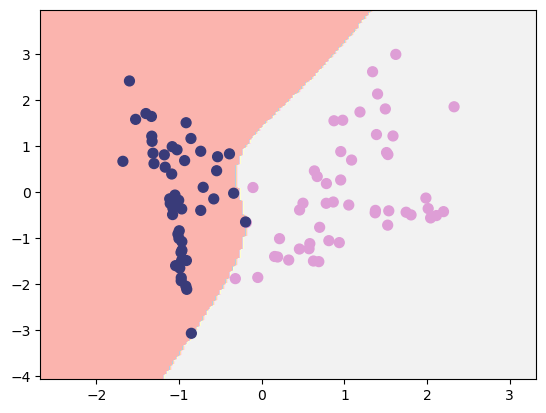

In [821]:
plot_2d_clf_problem(X, y, lambda x : regression2.predict(poly3.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?